In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zl7zuene
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zl7zuene
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 317.7 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=3f2df27ffc5043c975cff594fabd167d2094ddf8213b946a87c37d8f120c9998
  Stored in directory: /tmp/pip-ephem-wheel-cache-acui_pq2/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import os
import torch
import clip
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torch.utils.data import Subset


In [3]:
# Load the model
device = "cuda"
# device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
cifar100 = CIFAR100(root="./", download=True, train=False)

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 35.4MiB/s]


100%|██████████| 169M/169M [00:05<00:00, 30.6MB/s]


Extracting ./cifar-100-python.tar.gz to ./


In [ ]:
image_path = "DrLu.png"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
text = clip.tokenize(["a man", "a woman", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)
display(Image.open(image_path))

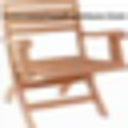


Top predictions:

           chair: 85.11%
           table: 3.57%
      lawn_mower: 1.66%
        wardrobe: 1.44%
           couch: 1.38%


In [ ]:
# Zero-Shot Prediction on CIFAR-100

# Prepare the inputs
image, class_id = cifar100[4444]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

display(image.resize((image.width * 4, image.height * 4)))

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

In [4]:
def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [5]:
# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)

# Create the subset dataset for initial hyperparameter search estimation
num_samples = len(train)
subset_size = int(num_samples * 0.2)
indices = torch.randperm(num_samples)[:subset_size]
train_subset = Subset(train, indices)

train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)
train_subset_features, train_subset_labels = get_features(train_subset)

100%|██████████| 169M/169M [00:03<00:00, 43.7MB/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


In [9]:
# Estimate hyperparameter C value on a subset of the training data
# around a previously estimated optimal C = 0.316

log_reg = LogisticRegression(random_state=0, max_iter=1000, verbose=1)

param_grid = {'C': [0.305, 0.310, 0.316, 0.320, 0.325]}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(train_subset_features, train_subset_labels)
best_classifier = grid_search.best_estimator_
print(f"Best C value: {grid_search.best_params_['C']}")

predictions = best_classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C value: 0.316
Accuracy = 75.830


In [11]:
# Train the model with the entire dataset with the estimated C value
best_classifier.fit(train_features, train_labels)

predictions = best_classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 80.070
